<a href="https://colab.research.google.com/github/rpizarrog/innovacion-empresarial/blob/main/notebook_python/Caso_02_Regresi%C3%B3n_Polinomial_con_datos_de_estaturas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivo

Construir e interpretar un modelo de regresión polinomial de segundo nivel




# Descripción

* Cargar librerías.
* Crear funciones.
* Cargar datos.
* Crear modelo de regresión polinomial a la segunda potencia.
* Identificar métricas *r square* con valor por encima del  50 % para aceptar el modelo y de RMSE cercano a 0 que deberá ser comparado con otro modelo de regresión.
* Partir en datos de entrenamiento y datos de validación con el  70 % y  30 %.
* Evaluar modelo con datos de entrenamiento con el valor *r square*.
* Visualizar curva de regresión con el modelo construído y los datos de entrenamiento.
* Realizar predicciones utilizando el modelo con los datos de validación.
* Evaluar el modelo con el estadístico *RMSE root mean square error*
* Interpretar el caso.



# Desarrollo



## Cargar librerías


In [131]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures # Polinomial


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
#%matplotlib inline

## Crear funciones



In [132]:
# Función que devuelve las medias aritméticas y desviaciones estándar de dos variables numéricas de una muestra
def f_medias (independiente, dependiente):
  medias = [np.mean(independiente), np.mean(dependiente)]
  return medias

def f_dispersion (x, y, x_nombre, y_nombre):
  medias = f_medias(x, y)

   # Crear el diagrama de dispersión
  plt.scatter(x, y, s = 5)

  # Etiquetas y título
  plt.xlabel(x_nombre)
  plt.ylabel(y_nombre)
  plt.title('Diagrama de Dispersión')
  plt.axvline(x=medias[0], color='blue', linestyle='--', linewidth=0.5,
            label="Media "+ x_nombre + ":" + str(np.round(medias[0], 2)))
  plt.axhline(y=medias[1], color='green', linestyle='--', linewidth=0.5,
            label="Media "+ y_nombre+":" + str(np.round(medias[1], 2)))
  plt.legend()
  # Mostrar el diagrama de dispersión
  plt.show()

# Función que devuelve la covariana y correlación de Pearson y r square de dos variables numéricas de una muestra
def f_cov_corr(independiente, dependiente):
  covar = np.cov(independiente, dependiente, ddof=1)[0,1]
  r = np.corrcoef(independiente, dependiente)[0,1]
  r_square = r ** 2
  return covar, r, r_square

# Función que visualiza la dispersión de los datos y la curva de tendencia

def f_regresion_curva_tendencia(modelo, x, y, xlabel, ylabel, grado):
  # Obtener el término de intercepción
  intercepto = modelo.intercept_
  print(f"Intercepto (β0): {intercepto}")

  # Obtener los coeficientes
  coeficientes = modelo.coef_
  print(f"Coeficientes (β1, β2, ...): {coeficientes}")
  # Crear un rango de valores en X para la predicción de la curva de tendencia
  x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)

  # Transformar los valores de X_range a características polinomiales
  poly_transformer = PolynomialFeatures(degree=grado)  # Asume que el modelo es de segundo grado
  x_range_poly = poly_transformer.fit_transform(x_range)

  # Predecir los valores de y para X_range usando el modelo
  predicciones = modelo.predict(x_range_poly)

  # Graficar los datos de entrenamiento
  plt.scatter(x, y, color='blue', s=5, label='Datos de entrenamiento')

  # Graficar la curva de tendencia
  plt.plot(x_range, predicciones, color='red', label='Curva de tendencia')

  # Añadir etiquetas y leyenda
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title('Regresión Polinomial')
  plt.legend()

  # Mostrar el gráfico
  plt.show()

## Cargar los datos


In [133]:
datos = datos = pd.read_csv("https://raw.githubusercontent.com/rpizarrog/innovacion-empresarial/main/datos/estaturas_pesos.csv", encoding='latin1')
print(datos)

    obs  estaturas  pesos
0     1        178     79
1     2        172     75
2     3        160     62
3     4        192    107
4     5        167     72
5     6        170     52
6     7        185     90
7     8        175     70
8     9        180     85
9    10        170     92
10   11        180     87
11   12        180     82
12   13        170     75
13   14        183     90
14   15        161     65
15   16        150     56
16   17        162     56
17   18        177     82
18   19        190     95
19   20        165     70
20   21        164     80
21   22        183     92
22   23        175     74
23   24        168     65
24   25        170     77
25   26        175     72
26   27        175     65
27   28        178     70
28   29        170     75
29   30        160     65
30   31        162     60
31   32        166     67
32   33        178     75
33   34        170     70
34   35        163     60
35   36        165     72
36   37        170     76
37   38     

## Dispersión de los datos



[178 172 160 192 167 170 185 175 180 170 180 180 170 183 161 150 162 177
 190 165 164 183 175 168 170 175 175 178 170 160 162 166 178 170 163 165
 170 167 159 165 181 170 172 171 178 165 162 187 189 174]
[ 79  75  62 107  72  52  90  70  85  92  87  82  75  90  65  56  56  82
  95  70  80  92  74  65  77  72  65  70  75  65  60  67  75  70  60  72
  76  78  60  68  76  60  75  78  76  64  62  87  90  72]


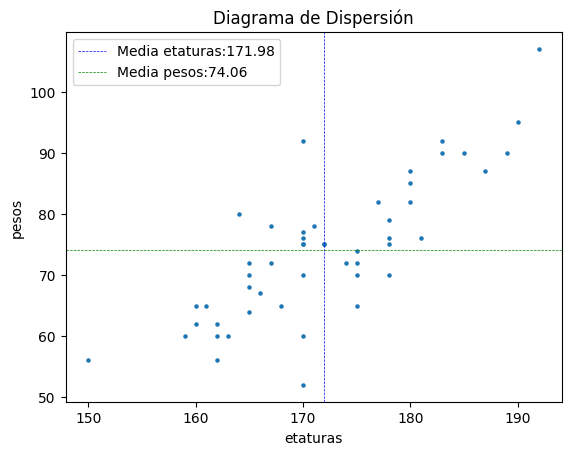

In [134]:
estaturas = datos['estaturas'].to_numpy()
pesos = datos['pesos'].to_numpy()

print (estaturas)
print(pesos)

f_dispersion(datos['estaturas'], datos['pesos'], "etaturas", "pesos")

## Crear datos de entrenamiento y validación

* Los datos de entrenamiento serán aleatoriamente el 70% de los datos originales.
* Los datos de validación o prueba (test) serán aleatoriamente el complemento del 30%.
* Los datos de entrenamiento y datos de validación deben
set mutuamente excluyentes que signifia que están en uno conjunto o están en el otro.

Ahora que se tiene la variable independiente estaturas y la variable dependiente pesos, el siguiente paso es dividir estos datos en conjuntos de entrenamiento y prueba o validación.

Se utiiza el método *train_test_split()* que forma parte de la librería Scikit-Learn para dividir los datos en entrenamiento y validación.

El argumento *test_size* establece el 30% para datos de validación por lo que el $70$% pertenece a los datos de entrenamiento y el resto a datos de validación o prueba.

In [135]:
estaturas_train, estaturas_test, pesos_train, pesos_test = train_test_split(estaturas, pesos, test_size=0.3,
                                                                            random_state=2024)

# Crear un DataFrame con los datos de entrenamiento
print ("Datos de entrenamiento")
datos_entrenamiento = pd.DataFrame({'estaturas': estaturas_train, 'pesos': pesos_train})

# Datos de entrenamiento
print(datos_entrenamiento)

# Crear un DataFrame con los datos de validación o test
datos_validacion = pd.DataFrame({'estaturas': estaturas_test, 'pesos': pesos_test})


# Datos de validación
print ("Datos de Validación")
print(datos_validacion)


Datos de entrenamiento
    estaturas  pesos
0         172     75
1         170     77
2         170     70
3         174     72
4         167     72
5         165     70
6         170     52
7         159     60
8         171     78
9         165     64
10        164     80
11        185     90
12        170     92
13        168     65
14        190     95
15        175     74
16        175     70
17        162     62
18        170     75
19        180     82
20        166     67
21        178     76
22        162     60
23        167     78
24        189     90
25        160     62
26        180     87
27        165     72
28        172     75
29        170     60
30        170     76
31        178     70
32        178     79
33        178     75
34        180     85
Datos de Validación
    estaturas  pesos
0         175     72
1         177     82
2         181     76
3         165     68
4         170     75
5         192    107
6         183     90
7         175     65
8         16

## r square con los datos de entrenamiento

In [136]:
cova, r, r_square =  f_cov_corr(estaturas_train, pesos_train)
print ("Con los datos de entrenamiento; r square = ", r_square)

Con los datos de entrenamiento; r square =  0.5127646600191095


## Métricas de evaluacuón

El modelo se acepta si el valor de *r square* sobrepasa el  50 % tanto con los datos de entrenamiento como con los datos de validación.

El modelo a través de la métrica *root mean square error (RMSE)* que significa que tanto varía las predicciones con respecto a los datos reales se deberá comparar con otros modelos y los mismos datos para evalura su rendimiento.

## Construir el modelo polinomial de segundo nivel

### Preprocesamiento de los datos

Convertir las características de entrada en características polinomiales de segundo grado.


In [143]:
# Preprocesamiento - Transformar las características de entrada
grado = 2  # Aquí modifiar el grado a tercer nivel o a quinto nivel
poly = PolynomialFeatures(degree=grado)
estaturas_train_poly = poly.fit_transform(estaturas_train.reshape(-1, 1))
estaturas_test_poly = poly.transform(estaturas_test.reshape(-1, 1))

### Construir y entrenar el modelo de regresión lineal

Utilizar las características polinomiales para entrenar el modelo.



In [138]:
# Construir y entrenar el modelo de regresión lineal
modelo_polinomial = LinearRegression()
modelo_polinomial.fit(estaturas_train_poly, pesos_train)

LinearRegression()

### Mostrar la curva de tendencia

Mandar llamar la función con el modelo creado


$$
predicciones = Y=β_0 +β_1\cdot x_i+β_2\cdot x_i
$$

* $Y$ es la predicción.
* $β_0$ es el coeficiente de intersección de la abcisa.
* $β_1$ y $β_2$ son los coeficientes elevados a la primera y segunda potencia respectivamente.
* $x_i$ es el valor de $x_i$ es decir los valores de la variable independiente.



Intercepto (β0): 223.01097115218664
Coeficientes (β1, β2, ...): [ 0.         -2.63613353  0.01027113]


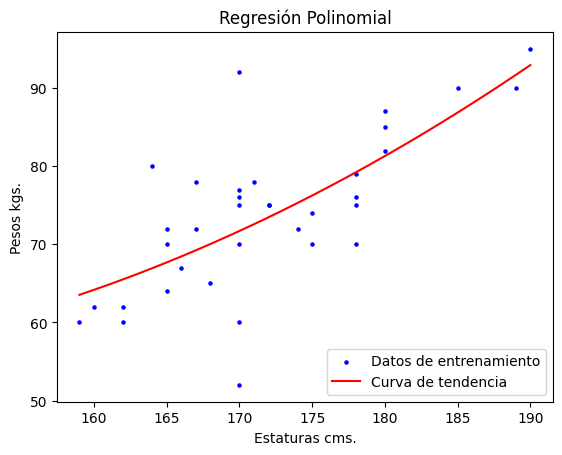

In [144]:
f_regresion_curva_tendencia(modelo_polinomial, estaturas_train.reshape(-1, 1),
                            pesos_train.reshape(-1, 1),
                             "Estaturas cms.", "Pesos kgs.", grado)



### Hacer predicciones

Usar el conjunto de validación para hacer predicciones y evaluar el rendimiento del modelo.

$$
\text{para x = 170 ¿Cual es la predicción aproximadamente?}
$$

$$
\text{predicción Y} =
223.01 + (−2.6361\times x_i) + (0.0102 \times x_i
 )\approx 71.7039
$$


In [140]:
# Predicciones
print ("Coeficiene intersección: ", modelo_polinomial.intercept_)
print ("Coeficientes de acuerdo a la potencia")
print (modelo_polinomial.coef_)

# Las predicciones
predicciones = modelo_polinomial.predict(estaturas_test_poly)
print(predicciones)



Coeficiene intersección:  223.01097115218664
Coeficientes de acuerdo a la potencia
[ 0.         -2.63613353  0.01027113]
[76.24083502 78.19944063 82.36315886 67.68034211 71.70381042 95.50811978
 84.56827149 76.24083502 65.51276815 66.21475055 58.69127498 64.831328
 84.56827149 64.17043011 89.22500377]


## Comparaciones

Crear un data.frame llamado comparaciones a partir de la creación de un diccionario con los valores reales del conjunto de validacipon y las predicciones calculadas.

Con la función flatten().tolist() convierte el arreglo a una lista de una dimensión.

In [141]:
diccionario = {'Estatura': estaturas_test.flatten().tolist(),
                'Real' : pesos_test.flatten().tolist(),
               'Predicho' : predicciones.flatten().tolist() }
# diccionario

comparaciones = pd.DataFrame(diccionario)
print (comparaciones)

    Estatura  Real   Predicho
0        175    72  76.240835
1        177    82  78.199441
2        181    76  82.363159
3        165    68  67.680342
4        170    75  71.703810
5        192   107  95.508120
6        183    90  84.568271
7        175    65  76.240835
8        162    56  65.512768
9        163    60  66.214751
10       150    56  58.691275
11       161    65  64.831328
12       183    92  84.568271
13       160    65  64.170430
14       187    87  89.225004


## RMSE

¿Qué tanto se desvián las predicciones de los valores reales?

Error sstándar médio MSE
$$
MSE = \frac{\sum(predicho_i - real_i)^{2}}{n}
$$

Raiz del error estándar medio

$$
RMSE = \sqrt{\frac{\sum(predicho_i - real_i)^{2}}{n}}
$$

In [142]:
print('Mean Absolute Error: MAE', metrics.mean_absolute_error(pesos_test, predicciones))
print('Mean Squared Error: MSE', metrics.mean_squared_error(pesos_test, predicciones))
print('Root Mean Squared Error RMSE:', np.sqrt(metrics.mean_squared_error(pesos_test, predicciones)))

cova, r, r_square =  f_cov_corr(estaturas_test, pesos_test)
print ("Con los datos de validación; r square = ", r_square)

Mean Absolute Error: MAE 5.017240822262355
Mean Squared Error: MSE 37.93772257873551
Root Mean Squared Error RMSE: 6.159360565735335
Con los datos de validación; r square =  0.8102398802359017


# Interpretación

Se cargó un conjunto de datos con variables de interés estaturas y pesos corporales de personas.

Se construyó un modelo de regresión polinómica a segundo nivel con datos de entrenamiento. La variable estaturas fué la variable predictora o independiente y la variable peso fue la variable objetivo o dependiente.

A partir el modelo de regresión polinómica se extrajeron los coeficientes de la abcisa o intersección y los coeficientes.

Coeficiene intersección:  223.01097115218664
Coeficientes de acuerdo a la potencia
[ 0.         -2.63613353  0.01027113]

Estos valores significan los valores para la estimación de acuerdo al modelo.

Se visualizó la dispersión de los datos con los valores de entrenamiento y se estimó la curva de regresión presentada también visualmente.

Habiendo relizado una evaluación del modelo con datos de entrenamiento o datos que se utilizaron para construir el modelo con el estadístico *r quare* o coeficiente de determinación se encontró que el valor de estaturas representa aproximadamente un  51  % al valor del peso corporal de una persona.

Se utilizaron datos de prueba o datos de validación con las mismas variables de estaturas y pesos para construir predicciones.

Habiendo relizado una evaluación del modelo con los datos de validación o datos de prueba con el estadístico *r square* o coeficiente de determinación se encontró que el valor de estatura representa aproximadamente un 81 % al valor del peso corporal de una persona.

El modelo se acepta datos que el valor de *r square* como métrica establecida inicialmente sobrepasa el 50 % tanto con los datos de entrenamiento como con los datos de validación.

El valor de *RMSE root mean square error* o error cuadrático medio significa eu tanto el modelo es eficiente y su valor cercano a cero representa esa eficiencia. El valor fue de  6.15  aproximadamente y debe ser comparado contra otro modelo para medir su eficiencia en relación con otros.

Comparado contra el modelo de regresión linel simple es mejor el modelo polinómico de segundo nivel ya que RMSE es menor

!Hasta la próxima!